In [4]:
import pandas as pd
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.4.1


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 7

TRAIN_PATH = '../train'
VALID_PATH = '../valid'
TEST_PATH = '../test'

classes = {0 : "aff",
           1 : "control"}

In [24]:

def data_augment(image):
    # p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    #p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    #p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    #if p_spatial > .75:
    #    image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # # Pixel-level transforms
    # if p_pixel_1 >= .4:
    #     image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    # if p_pixel_2 >= .4:
    #     image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    # if p_pixel_3 >= .4:
    #     image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [28]:
datagen = ImageDataGenerator(rescale = 1./255,
                             horizontal_flip=True,
                             samplewise_center = True,
                             samplewise_std_normalization = True,
                             preprocessing_function = data_augment)

In [29]:
train_gen = datagen.flow_from_directory(directory = TRAIN_PATH,
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'binary',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

datagen_notrain = ImageDataGenerator(rescale=1./255)
valid_gen = datagen_notrain.flow_from_directory(directory = VALID_PATH,
                                        batch_size = 1,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'binary',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

test_gen = datagen_notrain.flow_from_directory(directory = TEST_PATH,
                                        batch_size = 1,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = False,
                                        class_mode = 'binary',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

Found 2600 images belonging to 2 classes.
Found 870 images belonging to 2 classes.
Found 864 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 224 pixels width and 224 pixels height, one single color channel.
The maximum pixel value is 6.7376 and the minimum is -3.1017
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


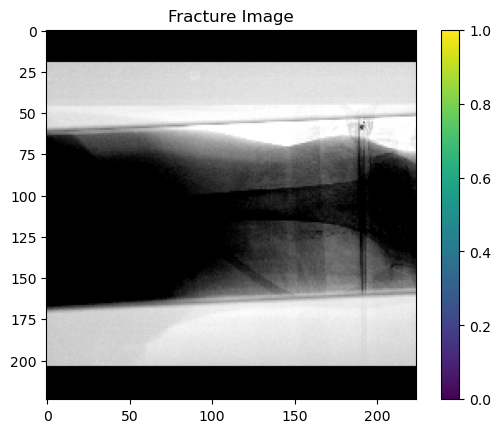

In [30]:
#sns.set_style('white')
generated_image, label = train_gen.__getitem__(10)
plt.imshow(generated_image[7])

plt.colorbar()
plt.title('Fracture Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [31]:
from vit_keras import vit

In [32]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'sigmoid',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 1)

353255424/353253686 [==============================] - 45s 0us/step


In [34]:
from vit_keras import visualize

x = train_gen.next()
image = x[0]

attention_map = visualize.attention_map(model = vit_model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:3689: error: (-215:Assertion failed) !dsize.empty() in function 'resize'


In [35]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, 'sigmoid')
    ],
    name = 'vision_transformer')

In [36]:
model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87455232  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 11)                8459      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11)                44        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 12        
Total params: 87,466,819
Trainable params: 87,465,261
Non-trainable params: 1,558
________________________________

In [37]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

2022-12-07 21:46:15.425805: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-07 21:46:15.426319: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3492035000 Hz


Epoch 1/7


2022-12-07 21:46:50.586988: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-07 21:46:55.849385: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
